In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
import sqlalchemy
import sqlite3 as sq

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import dataset from Google Drive:
url = ('https://drive.google.com/file/d/12tJP9WbbccaGDR0ugph6BW1aBkZeT-vA/view?usp=sharing')
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

df = pd.read_csv(path, dtype='str')

In [3]:
# Trim all whitespace from start & end of all data:
def trim_all_columns(df):
    def trim_strings(x): return x.strip() if isinstance(x, str) else x
    df.applymap(trim_strings)

trim_all_columns(df)

In [4]:
# Filter the database to show only shipments with a delivery date:
df['Delivery Date'] = df[df['Delivery Date'].notna()]

In [5]:
# Drop columns with high percentages of null values:
df = df.drop(['Bill To CAC', 'Consignee CAC', 'Shipper CAC', 'Close Employee Title',
              'Close Timestamp', 'Close Employee Nbr', 'Bill To Acct', 'LTC Center - Shift',
              'Unit Nbr', 'SLC', 'Concealed', 'Shipper Name'], axis=1)

In [6]:
# Set date columns to correct data type:
df['SQI Date'] = pd.to_datetime(df['SQI Date'])
df['Handled Date'] = pd.to_datetime(df['Handled Date'])
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'])

In [7]:
# All locations missing values are in the NA district, replace all nulls with 'NA':
df['Origin District'] = df['Origin District'].fillna('NA')

In [8]:
# All locations missing values are in the NA district, replace all nulls with 'NA':
df['LTC District'] = df['LTC District'].fillna('NA')

In [9]:
# All locations missing values are in the NA district, replace all nulls with 'NA':
df['Dest District'] = df['Dest District'].fillna('NA')

In [10]:
# Change all ',' employee names to 'UNK':
df['Employee Name'] = df['Employee Name'].replace({',': 'UNK'})
df = df.rename(columns={'Shipper Name.1': 'Shipper Name',
                        'LH Excep Noted': 'LH Exception Noted'})

In [11]:
# Create new column with hour range:
df['Handled Hour'] = df['Handled Time'].str[0:2].replace({'00': '00:00-00:59', '0:': '00:00-00:59',
                                                          '01': '01:00-01:59', '1:': '01:00-01:59',
                                                          '02': '02:00-02:59', '2:': '02:00-02:59',
                                                          '03': '03:00-03:59', '3:': '03:00-03:59',
                                                          '04': '04:00-04:59', '4:': '04:00-04:59',
                                                          '05': '05:00-05:59', '5:': '05:00-05:59',
                                                          '06': '06:00-06:59', '6:': '06:00-06:59',
                                                          '07': '07:00-07:59', '7:': '07:00-07:59',
                                                          '08': '08:00-08:59', '8:': '08:00-08:59',
                                                          '09': '09:00-09:59', '9:': '09:00-09:59',
                                                          '10': '10:00-10:59',
                                                          '11': '11:00-11:59',
                                                          '12': '12:00-12:59',
                                                          '13': '13:00-13:59',
                                                          '14': '14:00-14:59',
                                                          '15': '15:00-15:59',
                                                          '16': '16:00-16:59',
                                                          '17': '17:00-17:59',
                                                          '18': '18:00-18:59',
                                                          '19': '19:00-19:59',
                                                          '20': '20:00-20:59',
                                                          '21': '21:00-21:59',
                                                          '22': '22:00-22:59',
                                                          '23': '23:00-23:59'})

In [12]:
# Fix column name, create now column reflecting abbreviated days of the week:
df['Failure Type'] = df['Failure Type'].replace({'Damage-refused': 'Damage-Refused'})
df['Weekday'] = df['Handled Date'].dt.strftime('%a').str.upper()

In [13]:
# Replace remaining unknown values with 'UNK' 
df['Job Title'] = df['Job Title'].fillna('UNK')
df['Employee Nbr'] = df['Employee Nbr'].fillna('UNK')
df['Shipper Name'] = df['Shipper Name'].fillna('UNK')
df['Shipper Nbr'] = df['Shipper Nbr'].fillna('UNK')

In [14]:
# Rename the database that has been cleaned, add underscores in column names:
df.columns = df.columns.str.replace(' ', '_') 
df.columns = df.columns.str.replace('/', '_')

## CREATE SQLITE DATABASE FOR DATA

In [15]:
fishfinder_data = df

In [16]:
fishfinder_data_copy = fishfinder_data.copy()

In [17]:
sql_data = 'fishfinder_app.sqlite'

In [18]:
# Create connection & push the data:

conn = sq.connect(sql_data)
cur = conn.cursor()

cur.executescript('''
DROP TABLE IF EXISTS "FISHFINDER";
CREATE TABLE "FISHFINDER" (
	"index" INTEGER PRIMARY KEY AUTOINCREMENT,
	"SQI_Date" DATE NOT NULL,
	"Failure_Type" CHAR NOT NULL,
	"Pro_Number" CHAR NOT NULL,
	"Employee_Nbr" CHAR NOT NULL,
    "Employee_Name" CHAR NOT NULL,
    "Job_Title" CHAR NOT NULL,
    "Handled_Time" CHAR NOT NULL,
    "Handled_Date" CHAR NOT NULL,
    "LTC_Center" CHAR NOT NULL,
    "LTC_District" CHAR NOT NULL,
    "LTC_Region" CHAR NOT NULL,
    "Delivery_Date" DATE NOT NULL,
    "Origin_Center" CHAR NOT NULL, 
    "Origin_District" CHAR NOT NULL,
    "Origin_Region" CHAR NOT NULL,
    "Dest_Center" CHAR NOT NULL,
    "Dest_District" CHAR NOT NULL,
    "Dest_Region" CHAR NOT NULL,
    "Consignee_Name" CHAR NOT NULL,
    "Consignee_Nbr" CHAR NOT NULL,
    "Shipper_Name" CHAR NOT NULL,
    "Shipper_Nbr" CHAR NOT NULL,
    "Service" CHAR NOT NULL,
    "Live_Spot" CHAR NOT NULL,
    "Shift" CHAR NOT NULL,
    "Refused" CHAR NOT NULL,
    "LH_Exception_Center" CHAR NOT NULL,
    "LH_Exception_Noted" CHAR NOT NULL,
    "Last_Close_Center" CHAR NOT NULL,
    "Last_Closed_Trailer" CHAR NOT NULL,
    "Close_Employee_Name" CHAR NOT NULL,
    "Handled_Hour" CHAR NOT NULL,
    "Weekday" CHAR NOT NULL
);

''')

In [19]:
# conn.commit()
fishfinder_data.to_sql("FISHFINDER", conn, if_exists='append', index=True)
conn.commit()
conn.close()
# Reflect the Tables into SQLAlchemy ORM
engine = create_engine("sqlite:///fishfinder_app.sqlite")
# Reflect an existing database into a new model:
Base = automap_base()
# Reflect the tables:
Base.prepare(engine, reflect=True)
# Save reference to the combined table:
fishfinder = Base.classes.FISHFINDER
# Create our session (link) from Python to the DB:
session = Session(engine)

## QUERY DATA FOR DATE RANGES

In [20]:
# Filter start & end:
SET1_SD = input('Enter 1ST SET start date (YYYY-mm-dd)')
SET1_ED = input('Enter 1ST SET end date (YYYY-mm-dd)')

# Comparison start & end
SET2_SD = input('Enter 2ND SET start date (YYYY-mm-dd)')
SET2_ED = input('Enter 2ND SET end date (YYYY-mm-dd)')

Enter 1ST SET start date (YYYY-mm-dd)2019-06-24
Enter 1ST SET end date (YYYY-mm-dd)2019-06-30
Enter 2ND SET start date (YYYY-mm-dd)2019-06-17
Enter 2ND SET end date (YYYY-mm-dd)2019-06-23


In [21]:
# Perform a query to retrieve the main data from the FISHFINDER table:
from sqlalchemy import cast,Text
results = []
results = session.query(fishfinder.Handled_Date,
                        fishfinder.Shift,
                        fishfinder.LTC_Center,
                        fishfinder.Service,
                        fishfinder.Failure_Type,
                        fishfinder.Handled_Hour,
                        fishfinder.Weekday).filter(\
                            fishfinder.Handled_Date >= SET1_SD,
                            fishfinder.Handled_Date <= SET1_ED)

df1 = pd.DataFrame(results, columns=['Handled Date',
                                    'Shift',
                                    'LTC Center',
                                    'Service',
                                    'Failure Type',
                                    'Handled Hour',
                                    'Weekday'])

df1['Handled Date'] = pd.to_datetime(df1["Handled Date"]).dt.date

In [22]:
# Perform a query to retrieve the comparison data from the FISHFINDER table:
from sqlalchemy import cast,Text
results2 = []
results2 = session.query(fishfinder.Handled_Date,
                        fishfinder.Shift,
                        fishfinder.LTC_Center,
                        fishfinder.Service,
                        fishfinder.Failure_Type,
                        fishfinder.Handled_Hour,
                        fishfinder.Weekday).filter(\
                            fishfinder.Handled_Date >= SET2_SD,
                            fishfinder.Handled_Date <= SET2_ED)

df2 = pd.DataFrame(results2, columns=['Handled Date',
                                    'Shift',
                                    'LTC Center',
                                    'Service',
                                    'Failure Type',
                                    'Handled Hour',
                                    'Weekday'])

df2['Handled Date'] = pd.to_datetime(df2["Handled Date"]).dt.date

## CREATE USER INPUTS FOR SEARCH FILTERS

In [39]:
# LTC Center input with defaults set as all locations:
LTC = list(input('Enter LTC location (ALL CAPS): ').upper().strip().split(','))
if LTC == ['']:
    LTC = (list(df1['LTC Center'].unique()))

# LTC Center comparison defaults set as all locations or input:    
if len(LTC)==1:
    LTC0 = LTC
else:
    LTC0 = (list(df2['LTC Center'].unique()))

Enter LTC location (ALL CAPS): nas


In [25]:
# Shift input with defaults set as all shifts:
SHIFT = list(input('Inbound, Outbound, or Hub (enter one): ').capitalize().strip().split(','))
if SHIFT == ['']:
    SHIFT = list(df1['Shift'].unique())

Inbound, Outbound, or Hub (enter one): outbound


In [26]:
# Service input with defaults set as all shifts:
SERVICE = list(input('PRTY or ECON (enter one): ').upper().strip().split(','))
if SERVICE == ['']:
    SERVICE = list(df1['Service'].unique())

PRTY or ECON (enter one): 


## CREATE DATAFRAMES FROM FILTERED DATA

In [27]:
# Create damage reference dataframe based on user inputs or default inputs:
damage = df1.loc[(df1['Shift'].isin(SHIFT)
                  & (df1['LTC Center'].isin(LTC))
                  & (df1['Service'].isin(SERVICE))
                  & (df1['Failure Type'] == 'Damage'))]

In [28]:
# Create shortage reference dataframe based on user inputs or default inputs:
shortage = df1.loc[(df1['Shift'].isin(SHIFT)
                    & (df1['LTC Center'].isin(LTC))
                    & (df1['Service'].isin(SERVICE))
                    & (df1['Failure Type'] == 'Shortage'))]

In [29]:
# Create refused reference dataframe based on user inputs or default inputs:
refused = df1.loc[(df1['Shift'].isin(SHIFT)
                   & (df1['LTC Center'].isin(LTC))
                   & (df1['Service'].isin(SERVICE))
                   & (df1['Failure Type'] == 'Damage-Refused'))]

In [30]:
# Create top layer total exception reference dataframe based on user inputs or default inputs:
toplayer_SET1 = df1.loc[(df1['Shift'].isin(SHIFT)
                        &df1['LTC Center'].isin(LTC))]

In [31]:
# Create middle layer damage reference dataframe based on user inputs or default inputs:
middlelayer_SET1 = df1.loc[(df1['Shift'].isin(SHIFT)
                           &df1['LTC Center'].isin(LTC)
                           &df1['Failure Type'].isin(['Shortage', 'Damage-Refused']))]

In [40]:
# Create top layer total exception reference dataframe based on user inputs or default inputs:
toplayer_SET2 = df2.loc[(df2['Shift'].isin(SHIFT)
                        & df2['LTC Center'].isin(LTC0))]

In [42]:
# Designate the order of the x axis for the charts:
order=['00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59',
       '06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59',
       '12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59',
       '18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59']

## CHART 1: STACKED LTC BY HOUR HANDLED

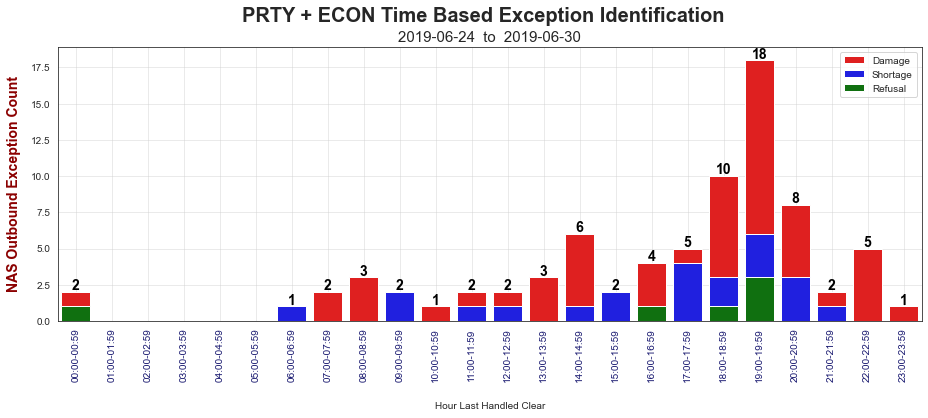

In [44]:
if LTC == (list(df1['LTC Center'].unique())):
    LTC1 = 'All Locations'
else:
    LTC1 = LTC[0]
if SHIFT == (list(df1['Shift'].unique())):
    SHIFT1 = 'All Shifts'
else:
    SHIFT1 = SHIFT[0]
if SERVICE == (list(df1['Service'].unique())):
    SERVICE1 = 'PRTY + ECON'
else:
    SERVICE1 = SERVICE[0]


sns.set_style('white')
plt.figure(figsize=(13, 6))
 
ax = sns.countplot(x='Handled Hour', data=toplayer_SET1, color='red',
                   order=order, label='Damage')
ax.tick_params(axis='x', colors='midnightblue')

# Add totals for all exceptions to the tops of the bars:
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',va='center',
                xytext=(0, 6),textcoords='offset points',
                size=14,color='black',weight='bold')

ax2 = sns.countplot(x='Handled Hour', data=middlelayer_SET1, color='blue',
                    order=order, label='Shortage')

ax3 = sns.countplot(x='Handled Hour', data=refused, color='green',
                    order=order, label='Refusal')

plt.suptitle(SERVICE1 +' Time Based Exception Identification', fontsize=20, fontweight='bold', y=0.96,x=0.52)

plt.title(SET1_SD+'  to  '+SET1_ED, size=15, y=1, x=0.5)

ax.grid(alpha=0.5)

plt.xticks(rotation='vertical')

ax.set_xlabel('Hour Last Handled Clear',
              labelpad=20)
ax.set_ylabel(LTC1+' '+SHIFT1+' Exception Count',color='darkred',weight='bold',size=14,labelpad=10)

plt.legend(loc=1)
plt.tight_layout()

#plt.savefig('plots/1_stacked_LTC_hour.jpg', bbox_inches='tight')

plt.show();

## CHART 2: LTC BY HOUR HANDLED

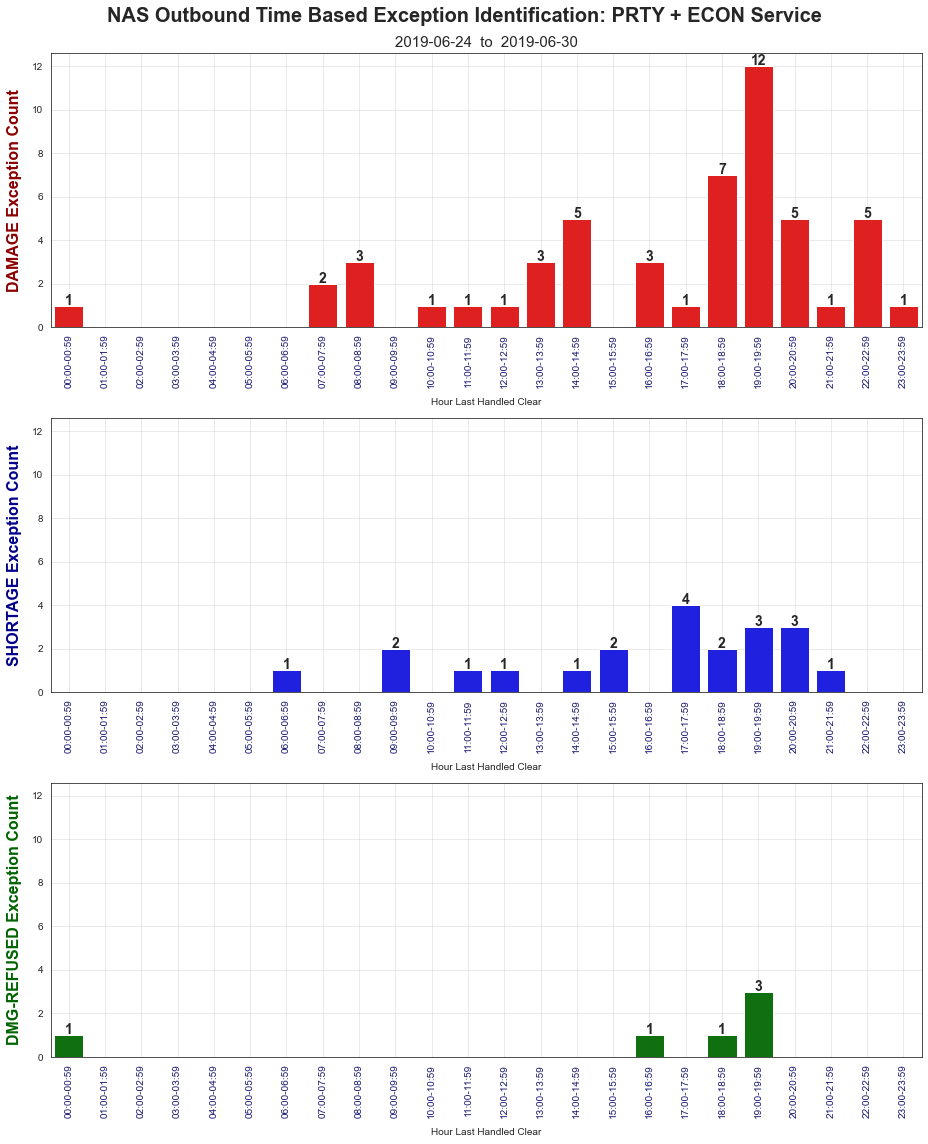

In [45]:
if LTC == (list(df1['LTC Center'].unique())):
    LTC2 = 'All Locations'
else:
    LTC2 = LTC[0]
if SHIFT == (list(df1['Shift'].unique())):
    SHIFT2 = 'All Shifts'
else:
    SHIFT2 = SHIFT[0]
if SERVICE == (list(df1['Service'].unique())):
    SERVICE2 = 'PRTY + ECON'
else:
    SERVICE2 = SERVICE[0]

plt.figure(figsize=(13, 16))

# ***** LTC Damages By Hour Handled: Position 1 *****

plt.subplot(311)

ax.subplot = sns.countplot(x='Handled Hour', data=damage, color='red',
                           order=order,label='Damage')
ax.subplot.tick_params(axis='x', colors='midnightblue')

plt.title(SET1_SD+'  to  '+SET1_ED, size=15, y=1, x=0.5)

ax.subplot.grid(alpha=0.5)

ax.subplot.set_ylabel('DAMAGE Exception Count'
                      ,color='darkred',weight='bold',size=16,
                      labelpad=10)
ax.subplot.set_xlabel('Hour Last Handled Clear',
                      labelpad=10)

# Add totals to the tops of the bars:
for p in ax.subplot.patches:
    y_value = p.get_height()
    x_value = p.get_x() + p.get_width() / 2  
    spacing = 5

    # Create annotation
    ax.subplot.annotate(
        '{:.0f}'.format(y_value),
        (x_value, y_value),
        xytext=(0, spacing),
        textcoords="offset points",
        ha='center',
        va = 'center',
        size=14,
        weight='bold')

plt.xticks(rotation='vertical')

# ***** LTC Shortages By Hour: Position 2 *****

plt.subplot(312)
plt.subplot(312,sharey=ax.subplot)
ax2.subplot = sns.countplot(x='Handled Hour', data=shortage, color='blue',
                            order=order)
ax2.subplot.tick_params(axis='x', colors='midnightblue')
ax2.subplot.grid(alpha=0.5)

ax2.subplot.set_ylabel('SHORTAGE Exception Count',
                       color='darkblue',weight='bold',size=16,
                       labelpad=10)
ax2.subplot.set_xlabel('Hour Last Handled Clear',
                       labelpad=10)

# Add totals to the tops of the bars:
for p in ax2.subplot.patches:
    y_value = p.get_height()
    x_value = p.get_x() + p.get_width() / 2  
    spacing = 5

    # Create annotation
    ax2.subplot.annotate(
        '{:.0f}'.format(y_value),
        (x_value, y_value),
        xytext=(0, spacing),
        textcoords="offset points",
        ha='center',
        va = 'center',
        size=14,
        weight='bold')

plt.xticks(rotation='vertical')

# ***** LTC Dmg-Refusals By Hour: Position 3 *****

plt.subplot(313)
plt.subplot(313,sharey=ax.subplot)
ax3.subplot = sns.countplot(x='Handled Hour', data=refused, color='green',
                            order=order)
ax3.subplot.tick_params(axis='x', colors='midnightblue')
ax3.subplot.grid(alpha=0.5)

ax3.subplot.set_ylabel('DMG-REFUSED Exception Count',
                       color='darkgreen',weight='bold',size=16,
                       labelpad=10)
ax3.subplot.set_xlabel('Hour Last Handled Clear',
                       labelpad=10)
    
# Add totals to the tops of the bars:
for p in ax3.subplot.patches:
    y_value = p.get_height()
    x_value = p.get_x() + p.get_width() / 2  
    spacing = 5

    # Create annotation
    ax3.subplot.annotate(
        '{:.0f}'.format(y_value),
        (x_value, y_value),
        xytext=(0, spacing),
        textcoords="offset points",
        ha='center',
        va = 'center',
        size=14,
        weight='bold')

plt.xticks(rotation='vertical')
plt.suptitle(LTC1+' '+SHIFT1+' '+'Time Based Exception Identification: '+SERVICE1+' Service', fontsize=20, fontweight='bold', y=0.99)
plt.tight_layout()
plt.savefig('plots/2_LTC_by_hour.jpg', bbox_inches='tight')
plt.show();


## CHART 3: LTC DAMAGE TOTALS BY DAY OF THE WEEK

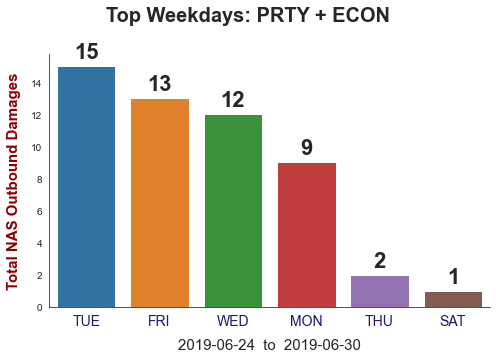

In [46]:
if LTC == (list(df1['LTC Center'].unique())):
    LTC3 = 'All Locations'
else:
    LTC3 = LTC[0]
if SHIFT == (list(df1['Shift'].unique())):
    SHIFT3 = 'All Shifts'
else:
    SHIFT3 = SHIFT[0]
if SERVICE == (list(df1['Service'].unique())):
    SERVICE3 = 'PRTY + ECON'
else:
    SERVICE3 = SERVICE[0]

plt.figure(figsize=(7, 5))

ax = sns.countplot(x="Weekday",data=damage,order=damage['Weekday'].value_counts().iloc[:7].index)

ax.set_xlabel(SET1_SD+'  to  '+SET1_ED,
             labelpad=10,size=15)

ax.set_ylabel('Total '+LTC3+' '+SHIFT3+' Damages',weight='bold',
             labelpad=10,size=15,color='darkred')

# Add totals to the tops of the bars:
for p in ax.patches:
    y_value = p.get_height()
    x_value = p.get_x() + p.get_width() / 2
    label = '{:.0f}'.format(y_value)
    va = 'bottom'
    spacing = 4

    # Create annotation
    ax.annotate(
        label,
        (x_value, y_value),
        xytext=(0, spacing),
        textcoords="offset points",
        ha='center',
        va=va,
        size=22,
        weight='bold')

# Remove the top and right borders from the plot area:
sns.despine()

plt.suptitle('Top Weekdays: '+SERVICE3, fontsize=20, fontweight='bold', y=0.99)
plt.setp(ax.get_xticklabels(), fontsize=14, color='midnightblue')

plt.tight_layout()
plt.savefig('plots/3_LTC_damage_day.jpg', bbox_inches='tight')

plt.show();

## CHART 4: LTC SHORTAGE TOTALS BY DAY OF THE WEEK

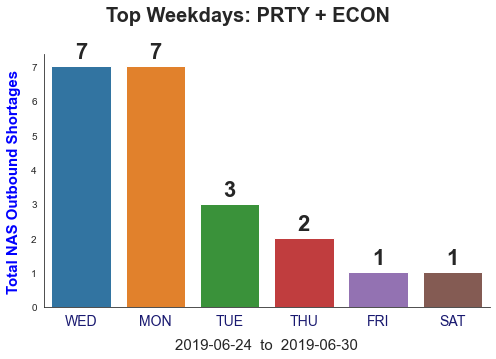

In [47]:
if LTC == (list(df1['LTC Center'].unique())):
    LTC4 = 'All Locations'
else:
    LTC4 = LTC[0]
if SHIFT == (list(df1['Shift'].unique())):
    SHIFT4 = 'All Shifts'
else:
    SHIFT4 = SHIFT[0]
if SERVICE == (list(df1['Service'].unique())):
    SERVICE4 = 'PRTY + ECON'
else:
    SERVICE4 = SERVICE[0]

plt.figure(figsize=(7, 5))
#plt.title(SET1_SD+'  to  '+SET1_ED, size=15, y=1, x=0.5)

ax = sns.countplot(x="Weekday",data=shortage,order=shortage['Weekday'].value_counts().iloc[:7].index)

ax.set_xlabel(SET1_SD+'  to  '+SET1_ED,
             labelpad=10,size=15)

ax.set_ylabel('Total '+LTC3+' '+SHIFT3+' Shortages',weight='bold',
             labelpad=10,size=15,color='blue')

# Add totals to the tops of the bars:
for p in ax.patches:
    y_value = p.get_height()
    x_value = p.get_x() + p.get_width() / 2
    label = '{:.0f}'.format(y_value)
    va = 'bottom'
    spacing = 4

    # Create annotation
    ax.annotate(
        label,
        (x_value, y_value),
        xytext=(0, spacing),
        textcoords="offset points",
        ha='center',
        va=va,
        size=22,
        weight='bold')

# Remove the top and right borders from the plot area:
sns.despine()

plt.suptitle('Top Weekdays: '+SERVICE3, fontsize=20, fontweight='bold', y=0.99)
plt.setp(ax.get_xticklabels(), fontsize=14, color='midnightblue')

plt.tight_layout()
plt.savefig('plots/4_LTC_short_day.jpg', bbox_inches='tight')

plt.show();

## CHART 5: LTC DAMAGE-REFUSED TOTALS BY DAY OF THE WEEK

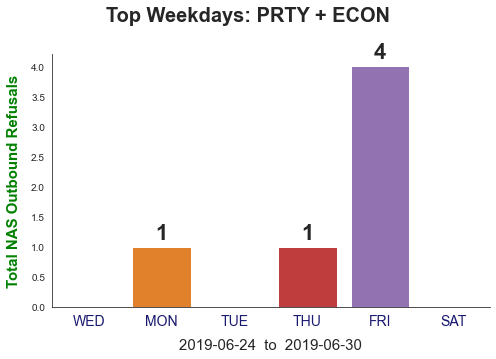

In [49]:
if LTC == (list(df1['LTC Center'].unique())):
    LTC5 = 'All Locations'
else:
    LTC5 = LTC[0]
if SHIFT == (list(df1['Shift'].unique())):
    SHIFT5 = 'All Shifts'
else:
    SHIFT5 = SHIFT[0]
if SERVICE == (list(df1['Service'].unique())):
    SERVICE5 = 'PRTY + ECON'
else:
    SERVICE5 = SERVICE[0]

plt.figure(figsize=(7, 5))
#plt.title(SET1_SD+'  to  '+SET1_ED, size=15, y=1, x=0.5)

ax = sns.countplot(x="Weekday",data=refused,order=shortage['Weekday'].value_counts().iloc[:7].index)

ax.set_xlabel(SET1_SD+'  to  '+SET1_ED,
             labelpad=10,size=15)

ax.set_ylabel('Total '+LTC3+' '+SHIFT3+' Refusals',weight='bold',
             labelpad=10,size=15,color='green')

# Add totals to the tops of the bars:
for p in ax.patches:
    y_value = p.get_height()
    x_value = p.get_x() + p.get_width() / 2
    label = '{:.0f}'.format(y_value)
    va = 'bottom'
    spacing = 4

    # Create annotation
    ax.annotate(
        label,
        (x_value, y_value),
        xytext=(0, spacing),
        textcoords="offset points",
        ha='center',
        va=va,
        size=22,
        weight='bold')

# Remove the top and right borders from the plot area:
sns.despine()

plt.suptitle('Top Weekdays: '+SERVICE3, fontsize=20, fontweight='bold', y=0.99)
plt.setp(ax.get_xticklabels(), fontsize=14, color='midnightblue')

plt.tight_layout()
plt.savefig('plots/5_LTC_refused_day.jpg', bbox_inches='tight')

plt.show();

## CREATE NEW DATAFRAME FOR TIME FRAME COMPARISONS

In [50]:
# Data for new DataFrame to ensure every hour is represented in comparison plot:
count = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# Create new base DataFrame:
base = pd.DataFrame([order,count]).transpose()
base.columns = ['Handled Hour','Base Count']

In [51]:
# Create new DataFrame for the filtered & comparison DataFrames:
filtered = toplayer_SET1['Handled Hour'].value_counts().sort_index()\
.rename_axis('Handled Hour').reset_index(name='Filtered Count')

compare = toplayer_SET2['Handled Hour'].value_counts().sort_index()\
.rename_axis('Handled Hour').reset_index(name='Comparison Count')

In [52]:
# Combine the base with filtered:
combined = base.merge(filtered, how='left', left_on='Handled Hour', right_on='Handled Hour')

# Add the compare totals to the new DataFrame:
combined = combined.merge(compare, how='left', left_on='Handled Hour', right_on='Handled Hour')
combined.columns = ['Handled Hour','Base','Filter','Compare']

In [53]:
# Replace NaN's with zeroes:
combined = combined.fillna(0)

In [54]:
# Get the change by subtracting the compare values from the filtered values:
combined['Change'] = (combined['Filter'] - combined['Compare'])

# Remove any NaN values if present:
combined = combined.fillna(0)

combined['Change'] = combined['Change'].astype(int)

In [55]:
# Create new column that can be referenced in the comparison plot:
increase = []
decrease = []

# Build the increase column values:
for i in combined['Change']:
    if i > 0:
        increase.append(i)
    else:
        increase.append(None)
combined['Increase'] = increase

# Build the decrease column values:        
for i in combined['Change']:
    if i < 0:
        decrease.append(i)
    else:
        decrease.append(None)
combined['Decrease'] = decrease

## CHART 6: LTC EXCEPTION COMPARISONS BY HOUR HANDLED

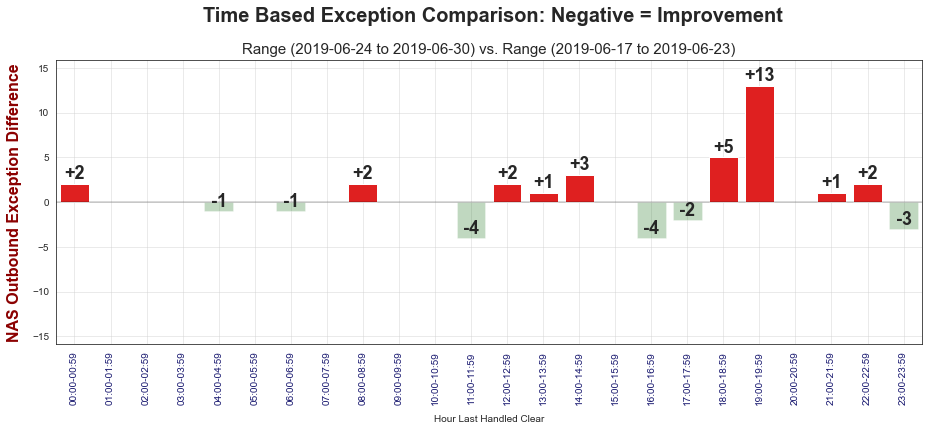

In [61]:
if LTC == (list(df1['LTC Center'].unique())):
    LTC6 = 'All Locations'
else:
    LTC6 = LTC[0]
if SHIFT == (list(df1['Shift'].unique())):
    SHIFT6 = 'All Shifts'
else:
    SHIFT6 = SHIFT[0]

plt.figure(figsize=(13, 6))

# Plot all increased & decreased y values on the same axis:
ax=sns.barplot(x='Handled Hour',y='Increase', data=combined, color='r')
ax=sns.barplot(x='Handled Hour',y='Decrease', data=combined, color='forestgreen', alpha=0.3)

# Ensure 0 value is always in the center of the plot:
yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max -2, ymax=yabs_max+2)

# Draw line at zero position:
ax.axhline(y=0.0,
           color='black',
           linestyle='-',
           linewidth=0.3)

plt.xticks(rotation='vertical')

plt.suptitle('Time Based Exception Comparison: Negative = Improvement',fontsize=20,fontweight='bold',y=0.99,x=0.53)

plt.title('Range ('+SET1_SD+' to '+SET1_ED+') vs. Range ('+SET2_SD+' to '+SET2_ED+')',size=15,y=1)

# Place values above & below each bar in the plot:
for p in ax.patches:
    y_value = p.get_height()
    x_value = p.get_x() + p.get_width() / 2

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        spacing = 18
        va = 'top'
        label = '{:.0f}'.format(y_value)
        
        
    # If value of bar is positive: Place label above bar
    if y_value > 0:
        label = '+'+ '{:.0f}'.format(y_value)
        va = 'bottom'
        spacing = 1

    # Create annotation
    ax.annotate(
        label,
        (x_value, y_value),
        xytext=(0, spacing),
        textcoords="offset points",
        ha='center',
        va=va,
        size=18,
        fontweight='bold')
    
ax.set_ylabel(LTC6+' '+SHIFT6+' Exception Difference',
              color='darkred',
              weight='bold',
              size=16,
              labelpad=10)

ax.set_xlabel('Hour Last Handled Clear',labelpad=10)
ax.tick_params(axis='x', colors='midnightblue')

ax.grid(alpha=0.5)    
    
plt.tight_layout()
plt.savefig('plots/6_LTC_comparison.jpg', bbox_inches='tight')
plt.show();